# Deep Learning Experiment - Pixel Classification

## Abstract

We take a naive approach to pixel classification (image segmentation) by machine learning with artificial neural networks. The focus here is on exploring practical issues like the preparation of data, python [1] programming and the use of the keras library [2]. The theroretical background of machine learning and deep learning is treated elsewhere [3].

Since we know that vectors of measurements can be classified by neural networks, we attempt to do image segmentation in the same way. We consider the NxN environment of each pixel of an image as a feature vector and classify each pixel as either belonging to the background or to an object of interest. Given a number of input images and corresponding ground truth images we extract the training and validation data. We build a neural network using keras, train it with the extracted training data and vaildate it using the extracted validation data. The created classidier is then applied on input images to create a segmentation mask and a probability map. 

The python programming constructs are explained along the process.

## Setup for Colab

When running in google colab, we need to install tifffile and update the keras version. We also need to download the dataset. 

In [1]:
import os
if  not os.path.isdir('./training'):
  !pip install tifffile
  !pip install -U keras
  !pip install mpld3
  !cd /content/ && git clone https://github.com/MontpellierRessourcesImagerie/DL_EXP_PC.git && cp -r DL_EXP_PC/data . && cp -r DL_EXP_PC/training .

## Reading in the training data

For simplicity we will use one image to construct the input data for now. We will generalize this to multiple images later. We have one input image and a correcponding ground-truth image as our training input.

As the input of the neural network we need a matrix X containing the input data and a vector y containing the classification for each row in the input matrix. We will construct X and y from the input dataset by first looking at the ground truth images and randomly choosing a number S of foreground samples and a number S of background samples. 

We set the paths to the input image and the ground-truth image, the patch size N and the number of samples S of foreground and background values.

In [2]:
inputPath = './training/spots.tif'
gtPath = './training/spots-gt.tif'
N = 3
S = 20000

We read in the input and the ground-truth image as numpy matrices.

In [3]:
import tifffile as tiff
gtImage = tiff.imread(gtPath)
inputImage = tiff.imread(inputPath) / 255
print(inputImage.shape)

(1830, 1980)


We filter out the background samples and the object samples from the ground-truth image.

In [4]:
import numpy as np
foregroundY, foregroundX = gtImage.nonzero()
foreground = list(zip(foregroundY, foregroundX))
backgroundY, backgroundX = (gtImage==0).nonzero()
background = list(zip(backgroundY, backgroundX))
print(background[0:10], "nr.:", len(background))
print(foreground[0:10], "nr.:", len(foreground))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)] nr.: 3412479
[(36, 1765), (36, 1766), (36, 1767), (36, 1768), (36, 1769), (37, 1764), (37, 1765), (37, 1766), (37, 1767), (37, 1768)] nr.: 210921


We select S randomly choosen coordinates from the foreground and S randomly choosen coordinates from the background. We do not take coordinates close to the borders for which the whole neighborhood is not inside of the image.

In [5]:
from random import randint
height, width = gtImage.shape
def getNCoordinateSamplesFrom(n, aList, minX, maxX, minY, maxY):
    samples = []
    for _ in range(n):
        r = randint(0,len(aList)-1)
        coords = aList[r]
        while coords[0]<=minY or coords[0]>=maxY or coords[1]<=minX or coords[1]>=maxX:    
            r = randint(0,len(foreground)-1)
            coords = foreground[r]
        samples.append(coords)
    return samples
FS = getNCoordinateSamplesFrom(S, foreground, N//2, width-N//2, N//2, height-N//2)
BS = getNCoordinateSamplesFrom(S, background, N//2, width-N//2, N//2, height-N//2)
print(FS[0:10])
print(BS[0:10])

[(806, 1852), (929, 270), (1125, 478), (165, 842), (1116, 464), (1493, 1788), (931, 288), (500, 1800), (374, 627), (707, 1179)]
[(1675, 1444), (266, 1939), (643, 1385), (1784, 225), (526, 1820), (1458, 1153), (350, 892), (610, 703), (1038, 750), (1600, 1692)]


We create X and y by using the data at the sampled positions in the input image. Since we have separate lists of foreground and background samples, we know to which class each sample must be assigned.

In [6]:
def addSamplesToTrainingData(n, image, samples, X, y, target):
    start = -n//2 + 1
    stop = -start + 1
    for ys, xs in samples:
        vector = []
        for i in range(start, stop):
            for j in range(start, stop):
                vector.append(image[ys+i,xs+j])
        X.append(vector)
        y.append(target)
    return X, y
X = []
y = []
addSamplesToTrainingData(N, inputImage, FS, X, y, 1)
addSamplesToTrainingData(N, inputImage, BS, X, y, 0)
X = np.array(X)
y = np.array(y)
print("foreground samples\n", X[0:5], y[0:5])
print("background samples\n", X[S:S+5], y[S:S+5])

foreground samples
 [[0.38823529 0.49019608 0.46666667 0.42352941 0.40784314 0.47058824
  0.38823529 0.38431373 0.43529412]
 [0.45490196 0.45490196 0.47058824 0.41176471 0.44705882 0.46666667
  0.41176471 0.45098039 0.45490196]
 [0.41568627 0.43921569 0.36470588 0.41176471 0.4        0.37254902
  0.43921569 0.41960784 0.37254902]
 [0.45490196 0.47058824 0.47058824 0.47843137 0.48627451 0.46666667
  0.48235294 0.48627451 0.48627451]
 [0.49803922 0.49019608 0.52156863 0.51372549 0.49019608 0.4627451
  0.49019608 0.49019608 0.46666667]] [1 1 1 1 1]
background samples
 [[0.31764706 0.3254902  0.33333333 0.32156863 0.33333333 0.32156863
  0.3254902  0.34117647 0.32941176]
 [0.29803922 0.31764706 0.32941176 0.31372549 0.31764706 0.32941176
  0.29019608 0.29803922 0.35686275]
 [0.31372549 0.3254902  0.30588235 0.32941176 0.3254902  0.30196078
  0.32941176 0.29411765 0.31372549]
 [0.36078431 0.32941176 0.32156863 0.3254902  0.33333333 0.33333333
  0.29019608 0.34117647 0.32156863]
 [0.29803922

The way we created X and y, we have S foreground samples followed by S background samples. This might not be ideal. The training will be done in mini-batches. The data will be shuffled automatically in the training before the mini-batches are created. However for validation a fraction of the data is taken from the end of the data before the shuffling is done. We therefore shuffle the data now.

In [7]:
seed = np.random.randint(0, 2**(32 - 1) - 1) 
rstate = np.random.RandomState(seed)
rstate.shuffle(X)
rstate = np.random.RandomState(seed)
rstate.shuffle(y)
print("first 5 of mixed samples\n", X[0:5], y[0:5])
print("last 5 of mixed samples\n", X[S:S+5], y[S:S+5])

first 5 of mixed samples
 [[0.50980392 0.4        0.42352941 0.44313725 0.49019608 0.48235294
  0.47058824 0.4745098  0.50196078]
 [0.3254902  0.3254902  0.3254902  0.3372549  0.30980392 0.30196078
  0.32941176 0.33333333 0.32156863]
 [0.30980392 0.31372549 0.32156863 0.28627451 0.29803922 0.30196078
  0.29411765 0.29803922 0.30588235]
 [0.44705882 0.47843137 0.49411765 0.45098039 0.4745098  0.48627451
  0.46666667 0.46666667 0.47843137]
 [0.27843137 0.29411765 0.29803922 0.28627451 0.27843137 0.27843137
  0.29803922 0.30196078 0.27058824]] [1 0 0 1 0]
last 5 of mixed samples
 [[0.30196078 0.30588235 0.31372549 0.3254902  0.30588235 0.28235294
  0.30588235 0.30980392 0.28627451]
 [0.2745098  0.31764706 0.29411765 0.29019608 0.30196078 0.30588235
  0.31372549 0.28627451 0.29411765]
 [0.45490196 0.52156863 0.45098039 0.5254902  0.49803922 0.51372549
  0.5254902  0.50196078 0.45882353]
 [0.30196078 0.28235294 0.31764706 0.30588235 0.29411765 0.29411765
  0.29803922 0.30588235 0.31764706]


## Creating a network using keras

As a first approach we create a simple, densly connected network with 4 layers inspired by [[4]](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/). We visualize the network architecture.

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


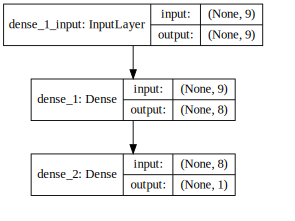

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import SVG
from keras.utils import model_to_dot

model = Sequential()
model.add(Dense(N*N-1, input_dim=(N*N), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## Training the network

We now run the training of the network and calculate and display the trainig loss and accuracy. We also use one fouth of the data for validation and calculate the validation accuracy and loss.

In [9]:
%%time
history = model.fit(X, y, validation_split=0.25, epochs=25, batch_size=128, verbose=0)
print("Loss: ", history.history['val_loss'][-1], "Accuracy: ", history.history['val_accuracy'][-1])

Loss:  0.046133837470412255 Accuracy:  0.988099992275238
CPU times: user 7.58 s, sys: 560 ms, total: 8.14 s
Wall time: 4.74 s


We visualize the training accuracy and loss history.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt, mpld3
def createSubplot(x, dataSeries, dataLabels, title, xLabel, yLabel, legendLoc, position):
    plt.subplot(position)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    for y, label in zip(dataSeries, dataLabels):
        plt.plot(x, y, label=label)
    plt.legend(loc=legendLoc)
xValues = np.arange(1., len(history.history['loss'])+1, 1)
plt.rcParams['xtick.major.pad']='16'
plt.rcParams['ytick.major.pad']='16'
plt.rcParams["figure.figsize"] = (15,5)
createSubplot(xValues, [history.history['accuracy'], history.history['val_accuracy']], 
              ["Training", "Validation"], "Model accuracy", "Epoch", "Accuracy",  "lower right", 121)
createSubplot(xValues, [history.history['loss'], history.history['val_loss']], 
              ["Training", "Validation"], "Model loss", "Epoch", "Loss", "upper right", 122)
plt.tight_layout(pad=3.0)
mpld3.display()

## Applying the model on images

We can now use the model to make predictions for the intensity vector of the neighborhood of a pixel.

In [11]:
prediction = model.predict(np.array([[128/255]*N*N]))
print(prediction[0][0])
classPrediction = model.predict_classes(np.array([[128/255]*N*N]))
print(classPrediction[0][0])

0.9997367
1


We will now use the model to segment images. We need to feed the neighborhood of all pixels to the classifier and create an output mask and a probability map from the result of the classification.

We set the path to the folder containing the input images. We will read each image in the folder, do the segmentation and save the result images.

Here is how it conceptually works. A loop iterates over the pixel in the input image. For each pixel a feature vector is created and classified from the intensities values in its neighborhood. It works but is very slow. We will therefore rather use an optimized version, that first creates a list of all feature vectors, passes them to the classification and then creates the mask and probability map from the results. However since the version not optimized is easier to understand, here it is:

```python
import os
path = './data'
files = os.listdir(path)
imagePaths = [os.path.join(path, f)  for f in files if not os.path.isdir(path + "/" + f)]
imagePaths.sort()
for imagePath in imagePaths:
    image = tiff.imread(imagePath) / 255
    width, height = image.shape
    pMap = np.zeros(image.shape)
    mask = np.zeros(image.shape)
    for x in range(0, width):
        if x%100 == 0:
            print(x)
        for y in range(0, height):
            neighborhood = []
            for i in range((-N//2)+1, (N//2)+1):
                for j in range((-N//2)+1, (N//2)+1):
                    ic = i
                    jc = j
                    if x+i < 0 or x+i>=width:
                        ic = -1 * i
                    if y+j < 0 or y+j>=height:
                        jc = -1 * j    
                    neighborhood.append(image[x+ic,y+jc])
            neighborhood = np.array([neighborhood])
            prob = model.predict(neighborhood)[0][0]
            category =  model.predict_classes(neighborhood)[0][0]
            pMap[x ,y] = prob * 255
            mask[x ,y] = category * 255
    print(pMap)
    print(mask)
```

### Making the segmentation faster

Although the segmentation above works, it is very slow. We will make it faster by applying the classification on bigger chunks of the image data, instead of classifying each pixel based on its neighborhood individually. We will first calculate the feature-vectors, i.e. the values in the neighboorhod for the whole image. Then we apply the classification. Instead of 2D output images we start with 1D arrays of size $width \times height$. We fill the linear array with the classification result and then reshape it to the 2D-image.

In [12]:
%%time
import os
path = './data'
out = os.path.join(path, 'out')
if not os.path.isdir(out):
    os.mkdir(out)
files = os.listdir(path)
imagePaths = [os.path.join(path, f)  for f in files if not os.path.isdir(path + "/" + f)]
imagePaths.sort()
for imagePath in imagePaths:
    print("Processing image " + imagePath)
    image = tiff.imread(imagePath) / 255
    width, height = image.shape
    neighborsRange = range((-N//2)+1, (N//2)+1)
    pMap = np.zeros(width*height)
    mask = np.zeros(width*height)
    neighborhoods = np.zeros((width*height, N*N), dtype=float)
    vc = 0
    print("Extracting the feature vectors.")
    for x in range(0, width):
        if x%10 == 0:
            print("\rRow: " + str(x), end="")
        for y in range(0, height):
            neighborhood = np.zeros(N*N)
            nc = 0
            for i in neighborsRange:
                for j in neighborsRange:
                    ic = i
                    jc = j
                    if x+i < 0 or x+i>=width:
                        ic = -1 * i
                    if y+j < 0 or y+j>=height:
                        jc = -1 * j    
                    neighborhood[nc] = image[x+ic,y+jc]
                    nc = nc + 1
            neighborhoods[vc]=neighborhood
            vc = vc + 1
    print("\nApplying the classifier.")
    prob = model.predict(neighborhoods)
    category =  model.predict_classes(neighborhoods)
    counter = 0
    print("Creating the output images.")
    for p in prob:
        pMap[counter] = p[0] * 255
        counter = counter + 1
    pMap = pMap.reshape(width, height)
    pMap = pMap.astype(np.uint8)
    outFileName = os.path.basename(imagePath)
    outFileName = os.path.splitext(outFileName)[0]
    outPath = os.path.join(out,outFileName + "-pMap.tif" )
    tiff.imwrite(outPath, pMap, imagej=True)
    counter = 0
    for c in category:
        mask[counter] = c[0] * 255
        counter = counter + 1
    mask = mask.reshape(width, height)
    mask = mask.astype(np.uint8)
    outPath = os.path.join(out,outFileName + "-mask.tif" )
    tiff.imwrite(outPath, mask, imagej=True)
    print("Done!")

Processing image ./data/spots01.tif
Extracting the feature vectors.
Row: 1820
Applying the classifier.
Creating the output images.
Done!
Processing image ./data/spots02.tif
Extracting the feature vectors.
Row: 1820
Applying the classifier.
Creating the output images.
Done!
CPU times: user 3min 7s, sys: 6.35 s, total: 3min 13s
Wall time: 2min 45s


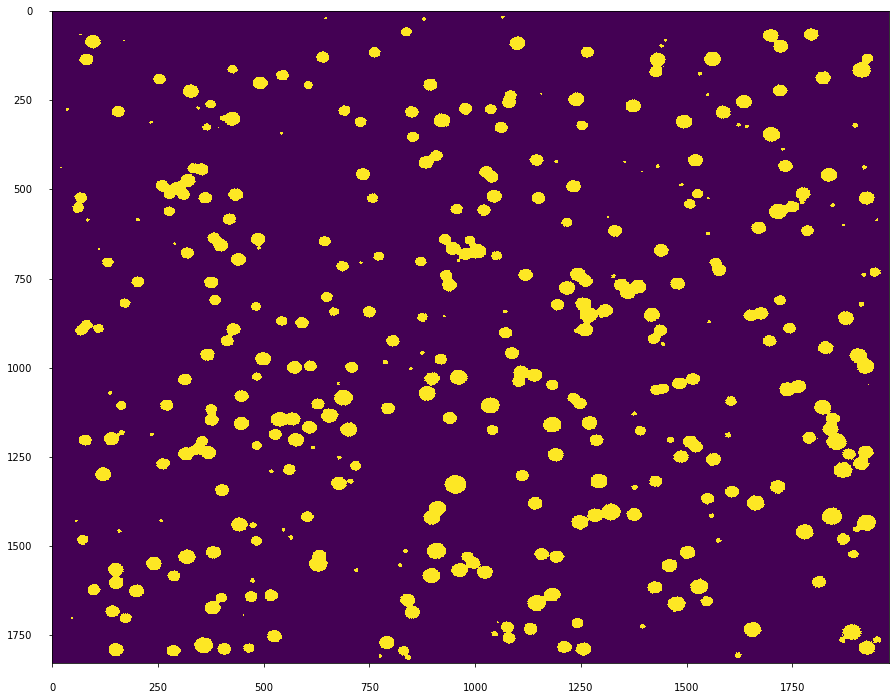

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,12))
plt.imshow(mask, interpolation='nearest', aspect="auto")
plt.show()

In [14]:
model.get_weights()

[array([[-0.46350053,  0.57324356, -0.12273103, -0.33291847,  0.29250497,
         -0.8996658 ,  0.32031614,  0.7490487 ],
        [-0.36048278,  0.24187724,  0.38324332, -0.5970291 , -0.424206  ,
         -0.64744264, -0.4226886 ,  0.7232532 ],
        [ 0.33146065,  1.2270366 , -0.53161395, -0.29318175, -0.18609771,
         -0.22382927, -0.15490353,  0.5326132 ],
        [-0.4756609 ,  1.0292846 , -0.18599588, -0.30825883,  0.5465611 ,
         -0.617859  , -0.0247547 ,  0.8972886 ],
        [-0.26620278,  1.2297844 , -0.47031662, -0.2605127 , -0.35975105,
         -0.42706168,  0.03288525,  0.619035  ],
        [-0.2953589 ,  0.44682533,  0.32834953, -0.1981439 , -0.01255059,
         -1.103296  ,  0.1858375 ,  1.2743654 ],
        [ 0.03219473,  1.0450197 , -0.29950076, -0.7600623 , -0.3041462 ,
         -0.45393428, -0.22564465,  1.017404  ],
        [ 0.09562504,  0.61901534, -0.5247766 , -0.97387075, -0.14669779,
         -0.2877862 , -0.33687025,  0.44544998],
        [-0.1367

## Literatur

[1] Van Rossum G, Drake FL. [Python 3 Reference Manual](https://docs.python.org/3/reference/index.html). Scotts Valley, CA: CreateSpace; 2009.

[2] Chollet F. and others. [Keras](https://keras.io). 2015

[3] [The MRI machine learning workshop](https://github.com/MontpellierRessourcesImagerie/mri-workshop-machine-learning). 2019

[4] Brownlee J. [Your First Deep Learning Project in Python with Keras Step-By-Step](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/). 2019